In [1]:
import pandas as pd
import numpy as np
from enum import Enum
import chess
from pathlib import Path
from typing import Tuple
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [2]:
if torch.cuda.is_available():
    device = "cuda" 
    print("CUDA version:", torch.version.cuda)
    print("GPU:", torch.cuda.get_device_name())
else:
    device = "cpu"
    
device

CUDA version: 12.9
GPU: NVIDIA GeForce RTX 3070


'cuda'

In [3]:
RUN_ID = "run_2026_01_15_probs_seresnet_droppath_c128_bn_v8"
model_save_name = "probs_seresnet_droppath_c128_bn_v8"

In [4]:
class NPZChessDataset(Dataset):
    def __init__(self, npz_path: Path, sigma: float = 0.6):
        with np.load(npz_path) as data:
            self.X = torch.tensor(data["X"], dtype=torch.float32) # float32 for NNs
            self.y = torch.tensor(data["y"], dtype=torch.long) # long for CrossEntropyLoss
            self.scores = torch.tensor(data["scores"], dtype=torch.float32)
            self.num_classes = 7
            self.sigma = sigma
            self.class_indices = torch.arange(self.num_classes, dtype=torch.float32)

    def __len__(self) -> int:
        return self.X.shape[0]

    def score_to_continuous_index(self, score: float) -> float:
        """
        Maps Centipawn score to a continuous index (e.g. 400cp -> 1.5).
        """
        
        if score >= 500: 
            # Fade from 0.5 (at 500) to 0.0 (at 700)
            return max(0.0, 0.5 - (score - 500) / 200.0)
        
        if score <= -500:
            # Fade from 5.5 (at -500) to 6.0 (at -700)
            return min(6.0, 5.5 + (-500 - score) / 200.0)
        
        # Interpolate the Middle Classes
        # 300 to 500  -> Maps to 1.5 to 0.5
        if score >= 300: return 1.5 - (score - 300) / 200.0
        # 100 to 300  -> Maps to 2.5 to 1.5
        if score >= 100: return 2.5 - (score - 100) / 200.0
        # -100 to 100 -> Maps to 3.5 to 2.5
        if score >= -100: return 3.5 - (score - (-100)) / 200.0
        # -300 to -100 -> Maps to 4.5 to 3.5
        if score >= -300: return 4.5 - (score - (-300)) / 200.0
        # -500 to -300 -> Maps to 5.5 to 4.5
        if score > -500: return 5.5 - (score - (-500)) / 200.0
        
        return 3.0 
    
    def __getitem__(self, idx) -> Tuple[torch.tensor, torch.tensor]:
        score = self.scores[idx].item()
        target_idx = self.score_to_continuous_index(score)
        
        # Create Gaussian Distribution centered at target_idx
        dist = torch.exp(-((self.class_indices - target_idx) ** 2) / (2 * self.sigma ** 2))
        
        # Normalize so it sums to 1.0
        soft_target = dist / dist.sum()

        # return self.X[idx], self.y[idx]
        return self.X[idx], soft_target

In [5]:
BATCH_SIZE = 512
num_workers = 0

TRAIN_PATH = Path("./dataset_planes_cp/plane_train.npz")
VAL_PATH = Path("./dataset_planes_cp/plane_val.npz")
TEST_PATH = Path("./dataset_planes_cp/plane_test.npz") 

train_dataloader = DataLoader(dataset=NPZChessDataset(TRAIN_PATH), 
                              batch_size=BATCH_SIZE, 
                              num_workers=num_workers,
                              shuffle=True,
                              pin_memory=True)
val_dataloader = DataLoader(dataset=NPZChessDataset(VAL_PATH), 
                            batch_size=BATCH_SIZE, 
                            num_workers=num_workers,
                            shuffle=False,
                            pin_memory=True)
test_dataloader = DataLoader(dataset=NPZChessDataset(TEST_PATH), 
                             batch_size=BATCH_SIZE, 
                             num_workers=num_workers,
                             shuffle=False,
                             pin_memory=True)

In [6]:
import time

start = time.time()
for i, (X, y) in enumerate(train_dataloader):
    if i == 100:  # measure 100 batches
        break
print("Avg batch load time:", (time.time() - start) / 100)


Avg batch load time: 0.03757648706436157


In [7]:
Xb, yb = next(iter(train_dataloader))
print("X batch shape:", Xb.shape, "dtype:", Xb.dtype)
print("y batch shape:", yb.shape, "dtype:", yb.dtype, "classes in batch:", yb.unique().tolist())

X batch shape: torch.Size([512, 19, 8, 8]) dtype: torch.float32
y batch shape: torch.Size([512, 7]) dtype: torch.float32 classes in batch: [1.5390388484403716e-22, 2.4929499023082824e-22, 2.926946588698798e-22, 5.127250047315728e-22, 5.553978106216665e-22, 6.516215239840385e-22, 1.138467397672646e-21, 1.2327396332385695e-21, 1.334754974040457e-21, 1.445149153615495e-21, 1.445149254589691e-21, 2.7250193005691556e-21, 3.1918971231280254e-21, 4.735892138511298e-21, 5.543729730207013e-21, 5.543730134103796e-21, 7.592190010612734e-21, 8.882322770937664e-21, 1.2150409973558108e-20, 1.2150410781351675e-20, 1.660784153315559e-20, 2.0983211767667695e-20, 2.6499246295431953e-20, 2.86404049266126e-20, 3.0952617076768396e-20, 3.6146500298860195e-20, 3.905876089758932e-20, 5.749384763504882e-20, 7.245696976711342e-20, 9.126960306189229e-20, 1.0642206554370057e-19, 1.3393902348914691e-19, 2.872175813985719e-19, 3.8906445281310485e-19, 4.196717381400037e-19, 4.19671789838792e-19, 4.882090802627919e-1

In [8]:
class PositionLabel(Enum):
    WHITE_WINNING = 0
    WHITE_DECISIVE = 1
    WHITE_BETTER = 2
    EQUAL = 3
    BLACK_BETTER = 4
    BLACK_DECISIVE = 5
    BLACK_WINNING = 6

In [14]:
class ResidualBlock(nn.Module):
    def __init__(self, channels, drop_prob=0.0):
        super().__init__()
        
        # bias = False because BatchNorm effectively cancels any bias term
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 =  nn.BatchNorm2d(channels)
        self.bn2 =  nn.BatchNorm2d(channels)
        self.relu = nn.ReLU()
        self.se = SEBlock(channels, reduction=8)
        self.drop_path = DropPath(drop_prob) if drop_prob > 0. else nn.Identity()

    # x is shape [19,8,8]
    def forward(self, x):
        identity = x 
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # x = self.dropout(x) # adding causes val acc drop 15%
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.se(x)
        x = self.drop_path(x)
        x += identity
        x = self.relu(x)
        # x = self.dropout(x) # adding causes val acc drop 15%
        return x

class SEBlock(nn.Module):
    def __init__(self, channels, reduction=8):
        super().__init__()
        # Squeeze: Global Average Pooling (turns Cx8x8 tensor into Cx1x1 tensor (not flattened))
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        
        # Excitation: A tiny fully connected network to learn channel weights
        self.mlp = nn.Sequential(
            nn.Linear(channels, channels // reduction), # Compress
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels), # Expand
            nn.Sigmoid() # Output a (0.0 to 1.0) for importance
        )

    def forward(self, x):
        batch, channels, _, _ = x.size()
        
        # Calculate importance scores
        y = self.avg_pool(x).view(batch, channels)
        y = self.mlp(y).view(batch, channels, 1, 1)
        
        # Scale the original input by these scores
        return x * y.expand_as(x)
    
class DropPath(nn.Module):
    def __init__(self, drop_prob: float = 0.):
        super().__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        if self.drop_prob == 0. or not self.training:
            return x
        
        keep_prob = 1 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)

        # Create a mask of 1s and 0s
        random_tensor = x.new_empty(shape).bernoulli_(keep_prob)

        # Apply mask and scale output to maintain expected value
        return x.div(keep_prob) * random_tensor
    
class SEResNet(nn.Module):
    def __init__(self, in_channels=19, channels=128, num_blocks=10, num_classes=7, drop_path_rate=0.2):
        super().__init__()
        # Initial convolution on board
        self.initialconv = nn.Sequential(
            nn.Conv2d(in_channels, channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(channels),
            nn.ReLU()
        )

        dpr = [x.item() for x in torch.linspace(start=0, end=drop_path_rate, steps=num_blocks)]

        # Main residual block
        blocks = []
        for i in range(num_blocks):
            blocks.append(ResidualBlock(channels, drop_prob=dpr[i]))
        self.res_tower = nn.Sequential(*blocks)


        # Reduces channels from 128 -> 32 before flattening
        self.bottleneck_channels = 32
        self.bottleneck = nn.Sequential(
            nn.Conv2d(channels, self.bottleneck_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(self.bottleneck_channels),
            nn.ReLU()
        )

        # Classifier
        self.flatten_dim = self.bottleneck_channels * 8 * 8
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flatten_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)      
        )

    def forward(self, x):
        x = self.initialconv(x)
        x = self.res_tower(x)
        x = self.bottleneck(x)
        x = self.classifier(x)
        return x

In [10]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               scaler: torch.amp.GradScaler,
               device=device) -> tuple[float, float]:
    """
    Performs one training epoch for the given model.
    Returns the average loss and accuracy across all batches.
    """
    
    # Put model in train mode
    model.train()

    train_loss, train_acc = 0, 0

    for batch, (X,y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device) # X and Y are both shape (BATCH_SIZE,)

        # Reset gradients
        optimizer.zero_grad()

        # Forward Pass
        with torch.amp.autocast(device):
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
        
        # Backpropagation
        scaler.scale(loss).backward()

        # Update weights
        scaler.step(optimizer)
        scaler.update()  
        
        train_loss += loss.item()

        # Calculate accuracy metrics
        """softmax and argmax dim=1 because tensor of shape (batchsize, num_classes)"""
        y_pred_class = torch.argmax(y_pred, dim=-1) # y_pred_class.shape = (BATCH_SIZE,)
        # train_acc += (y_pred_class == y).sum().item()/len(y_pred)

        # Remove for non prob ablation
        y_true_class = torch.argmax(y, dim=-1)
        train_acc += (y_pred_class == y_true_class).sum().item()/len(y_pred)
        
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc

In [11]:
def eval_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device) -> tuple[float, float]:
    """
    Evaluates the given model on the given dataloader without gradient updates.
    Dataloader should either be the validation or test dataloader.
    Returns the average loss and accuracy across all batches.
    """
    
    # Put model in eval mode
    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X,y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            # Forward Pass
            test_pred = model(X)

            # Calculate the loss
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

            # Calculate accuracy metrics
            test_pred_labels = torch.argmax(test_pred, dim=1)
            # test_acc += (test_pred_labels == y).sum().item()/len(test_pred_labels)

            # Remove for non prob ablation
            y_true_labels = torch.argmax(y, dim=1)
            test_acc += (test_pred_labels == y_true_labels).sum().item()/len(test_pred_labels)

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    return test_loss, test_acc

In [ ]:
from tqdm import tqdm
import copy

def run_experiment(model: torch.nn.Module,
                   model_save_name: str,
                   train_dataloader: torch.utils.data.DataLoader,
                   val_dataloader: torch.utils.data.DataLoader,
                   loss_fn: torch.nn.Module,
                   optimizer: torch.optim.Optimizer,
                   scaler: torch.amp.GradScaler,
                   epochs: int,
                   patience: int,
                   device=device):
    
    results = {"train_loss": [],
               "train_acc": [],
               "val_loss": [],
               "val_acc": []}
    
    best_val_acc = 0.0
    best_model_weights = None
    patience_counter = 0 
    
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    #     optimizer, mode='min', factor=0.1, patience=3
    # )

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, 
        T_max=epochs,      
        eta_min=1e-6         
    )
    
    print(f"Starting Training: {model_save_name}")

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device,
                                           scaler=scaler)
        val_loss, val_acc = eval_step(model=model,
                                      dataloader=val_dataloader,
                                      loss_fn=loss_fn,
                                      device=device)
        
        # scheduler.step(val_loss)
        scheduler.step()
        
        if val_acc > best_val_acc: 
            best_val_acc = val_acc
            best_model_weights = copy.deepcopy(model.state_dict())
            patience_counter = 0
            
            print(f"Epoch: {epoch} | New Best Val Acc: {val_acc:.4f} (Saved)")
            torch.save(model.state_dict(), f"models/{model_save_name}.pth")
        else:
            patience_counter += 1
            print(f"Epoch: No improvement. Patience {patience_counter}/{patience}")

        print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

        if patience_counter >= patience:
            print(f"\n[Early Stopping] No improvement for {patience} epochs. Stopping.")
            break 

    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)
        print(f"\nLoaded best model weights with Val Acc: {best_val_acc:.4f}")

    return results

In [15]:
from torchinfo import summary

model = SEResNet(in_channels=19, 
                 channels=128, 
                 num_blocks=10, 
                 num_classes=7).to(device)

summary(model, input_size=(BATCH_SIZE, 19, 8, 8))

Layer (type:depth-idx)                        Output Shape              Param #
SEResNet                                      [512, 7]                  --
├─Sequential: 1-1                             [512, 128, 8, 8]          --
│    └─Conv2d: 2-1                            [512, 128, 8, 8]          21,888
│    └─BatchNorm2d: 2-2                       [512, 128, 8, 8]          256
│    └─ReLU: 2-3                              [512, 128, 8, 8]          --
├─Sequential: 1-2                             [512, 128, 8, 8]          --
│    └─ResidualBlock: 2-4                     [512, 128, 8, 8]          --
│    │    └─Conv2d: 3-1                       [512, 128, 8, 8]          147,456
│    │    └─BatchNorm2d: 3-2                  [512, 128, 8, 8]          256
│    │    └─ReLU: 3-3                         [512, 128, 8, 8]          --
│    │    └─Conv2d: 3-4                       [512, 128, 8, 8]          147,456
│    │    └─BatchNorm2d: 3-5                  [512, 128, 8, 8]          256
│  

In [16]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 100

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(params=model.parameters(),
                              lr=0.001,
                              weight_decay=0.01)

scaler = torch.amp.GradScaler("cuda")

result = run_experiment(model=model,
                        model_save_name=model_save_name,
                        train_dataloader=train_dataloader,
                        val_dataloader=val_dataloader,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        scaler=scaler,
                        epochs=NUM_EPOCHS,
                        patience=NUM_EPOCHS + 1,
                        device=device)

Starting Training: probs_seresnet_droppath_c128_bn_v8


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0: New Best Val Acc: 0.5735 (Saved)


  1%|          | 1/100 [10:41<17:38:54, 641.76s/it]

Epoch: 0 | Train Loss: 1.3337 | Val Loss: 1.2525 | Val Acc: 0.5735


  2%|▏         | 2/100 [21:48<17:52:09, 656.42s/it]

Epoch 1: New Best Val Acc: 0.6144 (Saved)
Epoch: 1 | Train Loss: 1.2082 | Val Loss: 1.1867 | Val Acc: 0.6144


  3%|▎         | 3/100 [33:14<18:03:05, 669.95s/it]

Epoch 2: No improvement. Patience 1/101
Epoch: 2 | Train Loss: 1.1592 | Val Loss: 1.2142 | Val Acc: 0.5931


  4%|▍         | 4/100 [44:29<17:55:19, 672.08s/it]

Epoch 3: New Best Val Acc: 0.6502 (Saved)
Epoch: 3 | Train Loss: 1.1295 | Val Loss: 1.1405 | Val Acc: 0.6502


  5%|▌         | 5/100 [55:45<17:46:08, 673.35s/it]

Epoch 4: No improvement. Patience 1/101
Epoch: 4 | Train Loss: 1.1090 | Val Loss: 1.1318 | Val Acc: 0.6501


  6%|▌         | 6/100 [1:07:08<17:39:58, 676.58s/it]

Epoch 5: New Best Val Acc: 0.6509 (Saved)
Epoch: 5 | Train Loss: 1.0933 | Val Loss: 1.1323 | Val Acc: 0.6509


  7%|▋         | 7/100 [1:18:53<17:43:14, 685.97s/it]

Epoch 6: No improvement. Patience 1/101
Epoch: 6 | Train Loss: 1.0816 | Val Loss: 1.1851 | Val Acc: 0.6261


  8%|▊         | 8/100 [1:30:28<17:36:14, 688.86s/it]

Epoch 7: New Best Val Acc: 0.6756 (Saved)
Epoch: 7 | Train Loss: 1.0715 | Val Loss: 1.1029 | Val Acc: 0.6756


  9%|▉         | 9/100 [1:41:48<17:20:33, 686.08s/it]

Epoch 8: No improvement. Patience 1/101
Epoch: 8 | Train Loss: 1.0632 | Val Loss: 1.1036 | Val Acc: 0.6731


 10%|█         | 10/100 [1:52:40<16:53:10, 675.45s/it]

Epoch 9: No improvement. Patience 2/101
Epoch: 9 | Train Loss: 1.0565 | Val Loss: 1.1100 | Val Acc: 0.6714


 11%|█         | 11/100 [2:03:13<16:22:41, 662.49s/it]

Epoch 10: No improvement. Patience 3/101
Epoch: 10 | Train Loss: 1.0506 | Val Loss: 1.1781 | Val Acc: 0.6451


 12%|█▏        | 12/100 [2:14:10<16:09:03, 660.72s/it]

Epoch 11: No improvement. Patience 4/101
Epoch: 11 | Train Loss: 1.0455 | Val Loss: 1.1080 | Val Acc: 0.6714


 13%|█▎        | 13/100 [2:24:27<15:39:15, 647.76s/it]

Epoch 12: New Best Val Acc: 0.6772 (Saved)
Epoch: 12 | Train Loss: 1.0411 | Val Loss: 1.1035 | Val Acc: 0.6772


 14%|█▍        | 14/100 [2:34:25<15:06:40, 632.57s/it]

Epoch 13: New Best Val Acc: 0.6805 (Saved)
Epoch: 13 | Train Loss: 1.0372 | Val Loss: 1.0957 | Val Acc: 0.6805


 15%|█▌        | 15/100 [2:46:54<15:46:02, 667.80s/it]

Epoch 14: New Best Val Acc: 0.6843 (Saved)
Epoch: 14 | Train Loss: 1.0338 | Val Loss: 1.0958 | Val Acc: 0.6843


 16%|█▌        | 16/100 [2:59:03<16:00:37, 686.16s/it]

Epoch 15: No improvement. Patience 1/101
Epoch: 15 | Train Loss: 1.0304 | Val Loss: 1.1094 | Val Acc: 0.6723


 17%|█▋        | 17/100 [3:10:29<15:48:52, 685.93s/it]

Epoch 16: No improvement. Patience 2/101
Epoch: 16 | Train Loss: 1.0274 | Val Loss: 1.1020 | Val Acc: 0.6801


 18%|█▊        | 18/100 [3:20:34<15:04:15, 661.65s/it]

Epoch 17: No improvement. Patience 3/101
Epoch: 17 | Train Loss: 1.0251 | Val Loss: 1.0957 | Val Acc: 0.6836


 19%|█▉        | 19/100 [3:29:57<14:13:09, 631.97s/it]

Epoch 18: No improvement. Patience 4/101
Epoch: 18 | Train Loss: 1.0226 | Val Loss: 1.0985 | Val Acc: 0.6823


 20%|██        | 20/100 [3:39:18<13:34:26, 610.83s/it]

Epoch 19: No improvement. Patience 5/101
Epoch: 19 | Train Loss: 1.0202 | Val Loss: 1.1203 | Val Acc: 0.6648


 21%|██        | 21/100 [3:48:39<13:04:24, 595.75s/it]

Epoch 20: No improvement. Patience 6/101
Epoch: 20 | Train Loss: 1.0183 | Val Loss: 1.1028 | Val Acc: 0.6806


 22%|██▏       | 22/100 [3:58:02<12:41:56, 586.11s/it]

Epoch 21: No improvement. Patience 7/101
Epoch: 21 | Train Loss: 1.0161 | Val Loss: 1.1006 | Val Acc: 0.6834


 23%|██▎       | 23/100 [4:07:57<12:35:37, 588.79s/it]

Epoch 22: New Best Val Acc: 0.6867 (Saved)
Epoch: 22 | Train Loss: 1.0145 | Val Loss: 1.0963 | Val Acc: 0.6867


 24%|██▍       | 24/100 [4:17:21<12:16:16, 581.27s/it]

Epoch 23: New Best Val Acc: 0.6921 (Saved)
Epoch: 23 | Train Loss: 1.0123 | Val Loss: 1.0930 | Val Acc: 0.6921


 25%|██▌       | 25/100 [4:26:41<11:58:38, 574.91s/it]

Epoch 24: No improvement. Patience 1/101
Epoch: 24 | Train Loss: 1.0106 | Val Loss: 1.0947 | Val Acc: 0.6907


 26%|██▌       | 26/100 [4:36:01<11:43:34, 570.47s/it]

Epoch 25: No improvement. Patience 2/101
Epoch: 25 | Train Loss: 1.0089 | Val Loss: 1.0927 | Val Acc: 0.6907


 27%|██▋       | 27/100 [4:45:34<11:34:57, 571.19s/it]

Epoch 26: No improvement. Patience 3/101
Epoch: 26 | Train Loss: 1.0071 | Val Loss: 1.0960 | Val Acc: 0.6882


 28%|██▊       | 28/100 [4:54:54<11:21:12, 567.67s/it]

Epoch 27: No improvement. Patience 4/101
Epoch: 27 | Train Loss: 1.0054 | Val Loss: 1.1008 | Val Acc: 0.6902


 29%|██▉       | 29/100 [5:04:16<11:09:43, 565.97s/it]

Epoch 28: No improvement. Patience 5/101
Epoch: 28 | Train Loss: 1.0037 | Val Loss: 1.0968 | Val Acc: 0.6859


 30%|███       | 30/100 [5:15:23<11:35:49, 596.43s/it]

Epoch 29: No improvement. Patience 6/101
Epoch: 29 | Train Loss: 1.0022 | Val Loss: 1.1333 | Val Acc: 0.6660


 31%|███       | 31/100 [5:25:39<11:32:34, 602.23s/it]

Epoch 30: No improvement. Patience 7/101
Epoch: 30 | Train Loss: 1.0006 | Val Loss: 1.1110 | Val Acc: 0.6811


 32%|███▏      | 32/100 [5:35:38<11:21:23, 601.23s/it]

Epoch 31: No improvement. Patience 8/101
Epoch: 31 | Train Loss: 0.9988 | Val Loss: 1.0978 | Val Acc: 0.6880


 33%|███▎      | 33/100 [5:45:36<11:10:15, 600.23s/it]

Epoch 32: No improvement. Patience 9/101
Epoch: 32 | Train Loss: 0.9969 | Val Loss: 1.1013 | Val Acc: 0.6883
Epoch 33: New Best Val Acc: 0.6922 (Saved)


 34%|███▍      | 34/100 [5:55:36<11:00:16, 600.25s/it]

Epoch: 33 | Train Loss: 0.9958 | Val Loss: 1.0978 | Val Acc: 0.6922


 35%|███▌      | 35/100 [6:05:33<10:49:18, 599.36s/it]

Epoch 34: No improvement. Patience 1/101
Epoch: 34 | Train Loss: 0.9939 | Val Loss: 1.1025 | Val Acc: 0.6877


 36%|███▌      | 36/100 [6:15:54<10:46:05, 605.71s/it]

Epoch 35: No improvement. Patience 2/101
Epoch: 35 | Train Loss: 0.9923 | Val Loss: 1.1037 | Val Acc: 0.6901


 37%|███▋      | 37/100 [6:25:54<10:34:17, 604.09s/it]

Epoch 36: No improvement. Patience 3/101
Epoch: 36 | Train Loss: 0.9906 | Val Loss: 1.1030 | Val Acc: 0.6898


 38%|███▊      | 38/100 [6:35:57<10:23:46, 603.66s/it]

Epoch 37: New Best Val Acc: 0.6923 (Saved)
Epoch: 37 | Train Loss: 0.9889 | Val Loss: 1.1012 | Val Acc: 0.6923


 39%|███▉      | 39/100 [6:46:01<10:13:45, 603.69s/it]

Epoch 38: No improvement. Patience 1/101
Epoch: 38 | Train Loss: 0.9875 | Val Loss: 1.0983 | Val Acc: 0.6904


 40%|████      | 40/100 [6:56:02<10:03:00, 603.02s/it]

Epoch 39: No improvement. Patience 2/101
Epoch: 39 | Train Loss: 0.9857 | Val Loss: 1.1069 | Val Acc: 0.6905


 41%|████      | 41/100 [7:06:06<9:53:09, 603.21s/it] 

Epoch 40: No improvement. Patience 3/101
Epoch: 40 | Train Loss: 0.9839 | Val Loss: 1.1095 | Val Acc: 0.6882


 42%|████▏     | 42/100 [7:16:08<9:42:49, 602.92s/it]

Epoch 41: No improvement. Patience 4/101
Epoch: 41 | Train Loss: 0.9824 | Val Loss: 1.1069 | Val Acc: 0.6898


 43%|████▎     | 43/100 [7:26:10<9:32:27, 602.58s/it]

Epoch 42: New Best Val Acc: 0.6929 (Saved)
Epoch: 42 | Train Loss: 0.9807 | Val Loss: 1.1006 | Val Acc: 0.6929


 44%|████▍     | 44/100 [7:36:08<9:21:15, 601.35s/it]

Epoch 43: No improvement. Patience 1/101
Epoch: 43 | Train Loss: 0.9788 | Val Loss: 1.1062 | Val Acc: 0.6874


 45%|████▌     | 45/100 [7:46:06<9:10:12, 600.23s/it]

Epoch 44: No improvement. Patience 2/101
Epoch: 44 | Train Loss: 0.9769 | Val Loss: 1.1076 | Val Acc: 0.6892


 46%|████▌     | 46/100 [7:56:02<8:59:11, 599.10s/it]

Epoch 45: No improvement. Patience 3/101
Epoch: 45 | Train Loss: 0.9749 | Val Loss: 1.1063 | Val Acc: 0.6916


 47%|████▋     | 47/100 [8:06:02<8:49:25, 599.35s/it]

Epoch 46: No improvement. Patience 4/101
Epoch: 46 | Train Loss: 0.9733 | Val Loss: 1.1169 | Val Acc: 0.6840


 48%|████▊     | 48/100 [8:16:02<8:39:27, 599.37s/it]

Epoch 47: New Best Val Acc: 0.6947 (Saved)
Epoch: 47 | Train Loss: 0.9713 | Val Loss: 1.1081 | Val Acc: 0.6947


 49%|████▉     | 49/100 [8:26:07<8:30:56, 601.11s/it]

Epoch 48: No improvement. Patience 1/101
Epoch: 48 | Train Loss: 0.9695 | Val Loss: 1.1131 | Val Acc: 0.6921


 50%|█████     | 50/100 [8:36:05<8:20:14, 600.29s/it]

Epoch 49: No improvement. Patience 2/101
Epoch: 49 | Train Loss: 0.9675 | Val Loss: 1.1204 | Val Acc: 0.6874


 51%|█████     | 51/100 [8:46:04<8:09:52, 599.84s/it]

Epoch 50: No improvement. Patience 3/101
Epoch: 50 | Train Loss: 0.9655 | Val Loss: 1.1134 | Val Acc: 0.6936


 52%|█████▏    | 52/100 [8:56:03<7:59:46, 599.71s/it]

Epoch 51: No improvement. Patience 4/101
Epoch: 51 | Train Loss: 0.9637 | Val Loss: 1.1254 | Val Acc: 0.6832


 53%|█████▎    | 53/100 [9:06:28<7:55:34, 607.11s/it]

Epoch 52: No improvement. Patience 5/101
Epoch: 52 | Train Loss: 0.9616 | Val Loss: 1.1599 | Val Acc: 0.6736


 54%|█████▍    | 54/100 [9:16:26<7:43:25, 604.47s/it]

Epoch 53: No improvement. Patience 6/101
Epoch: 53 | Train Loss: 0.9595 | Val Loss: 1.1231 | Val Acc: 0.6842


 55%|█████▌    | 55/100 [9:26:19<7:30:41, 600.93s/it]

Epoch 54: No improvement. Patience 7/101
Epoch: 54 | Train Loss: 0.9574 | Val Loss: 1.1148 | Val Acc: 0.6933


 56%|█████▌    | 56/100 [9:36:26<7:22:06, 602.88s/it]

Epoch 55: New Best Val Acc: 0.6948 (Saved)
Epoch: 55 | Train Loss: 0.9552 | Val Loss: 1.1157 | Val Acc: 0.6948


 57%|█████▋    | 57/100 [9:46:19<7:10:00, 600.02s/it]

Epoch 56: No improvement. Patience 1/101
Epoch: 56 | Train Loss: 0.9534 | Val Loss: 1.1228 | Val Acc: 0.6921


 58%|█████▊    | 58/100 [9:56:13<6:58:44, 598.21s/it]

Epoch 57: No improvement. Patience 2/101
Epoch: 57 | Train Loss: 0.9509 | Val Loss: 1.1168 | Val Acc: 0.6938


 59%|█████▉    | 59/100 [10:06:09<6:48:10, 597.33s/it]

Epoch 58: No improvement. Patience 3/101
Epoch: 58 | Train Loss: 0.9488 | Val Loss: 1.1258 | Val Acc: 0.6914


 60%|██████    | 60/100 [10:16:04<6:37:51, 596.79s/it]

Epoch 59: No improvement. Patience 4/101
Epoch: 59 | Train Loss: 0.9465 | Val Loss: 1.1221 | Val Acc: 0.6933


 61%|██████    | 61/100 [10:25:58<6:27:16, 595.82s/it]

Epoch 60: No improvement. Patience 5/101
Epoch: 60 | Train Loss: 0.9444 | Val Loss: 1.1264 | Val Acc: 0.6924


 62%|██████▏   | 62/100 [10:35:50<6:16:42, 594.80s/it]

Epoch 61: No improvement. Patience 6/101
Epoch: 61 | Train Loss: 0.9422 | Val Loss: 1.1315 | Val Acc: 0.6926


 63%|██████▎   | 63/100 [10:45:43<6:06:27, 594.24s/it]

Epoch 62: No improvement. Patience 7/101
Epoch: 62 | Train Loss: 0.9399 | Val Loss: 1.1275 | Val Acc: 0.6936


 64%|██████▍   | 64/100 [10:55:36<5:56:20, 593.91s/it]

Epoch 63: New Best Val Acc: 0.6952 (Saved)
Epoch: 63 | Train Loss: 0.9375 | Val Loss: 1.1280 | Val Acc: 0.6952


 65%|██████▌   | 65/100 [11:05:30<5:46:24, 593.85s/it]

Epoch 64: No improvement. Patience 1/101
Epoch: 64 | Train Loss: 0.9352 | Val Loss: 1.1307 | Val Acc: 0.6927


 66%|██████▌   | 66/100 [11:15:24<5:36:30, 593.84s/it]

Epoch 65: No improvement. Patience 2/101
Epoch: 65 | Train Loss: 0.9331 | Val Loss: 1.1386 | Val Acc: 0.6918


 67%|██████▋   | 67/100 [11:25:19<5:26:49, 594.24s/it]

Epoch 66: No improvement. Patience 3/101
Epoch: 66 | Train Loss: 0.9309 | Val Loss: 1.1700 | Val Acc: 0.6765


 68%|██████▊   | 68/100 [11:35:13<5:16:53, 594.17s/it]

Epoch 67: No improvement. Patience 4/101
Epoch: 67 | Train Loss: 0.9286 | Val Loss: 1.1375 | Val Acc: 0.6946


 69%|██████▉   | 69/100 [11:45:07<5:07:00, 594.21s/it]

Epoch 68: No improvement. Patience 5/101
Epoch: 68 | Train Loss: 0.9261 | Val Loss: 1.1448 | Val Acc: 0.6934


 70%|███████   | 70/100 [11:55:01<4:57:01, 594.06s/it]

Epoch 69: No improvement. Patience 6/101
Epoch: 69 | Train Loss: 0.9237 | Val Loss: 1.1443 | Val Acc: 0.6922


 71%|███████   | 71/100 [12:04:55<4:47:08, 594.09s/it]

Epoch 70: No improvement. Patience 7/101
Epoch: 70 | Train Loss: 0.9215 | Val Loss: 1.1458 | Val Acc: 0.6930


 72%|███████▏  | 72/100 [12:14:50<4:37:19, 594.26s/it]

Epoch 71: No improvement. Patience 8/101
Epoch: 71 | Train Loss: 0.9193 | Val Loss: 1.1536 | Val Acc: 0.6928


 73%|███████▎  | 73/100 [12:24:47<4:27:49, 595.15s/it]

Epoch 72: No improvement. Patience 9/101
Epoch: 72 | Train Loss: 0.9171 | Val Loss: 1.1538 | Val Acc: 0.6940


 74%|███████▍  | 74/100 [12:34:41<4:17:42, 594.70s/it]

Epoch 73: No improvement. Patience 10/101
Epoch: 73 | Train Loss: 0.9148 | Val Loss: 1.1558 | Val Acc: 0.6934


 75%|███████▌  | 75/100 [12:44:34<4:07:36, 594.27s/it]

Epoch 74: No improvement. Patience 11/101
Epoch: 74 | Train Loss: 0.9127 | Val Loss: 1.1569 | Val Acc: 0.6928


 76%|███████▌  | 76/100 [12:54:43<3:59:25, 598.58s/it]

Epoch 75: No improvement. Patience 12/101
Epoch: 75 | Train Loss: 0.9104 | Val Loss: 1.1609 | Val Acc: 0.6917


 77%|███████▋  | 77/100 [13:06:28<4:01:47, 630.76s/it]

Epoch 76: No improvement. Patience 13/101
Epoch: 76 | Train Loss: 0.9084 | Val Loss: 1.1650 | Val Acc: 0.6929


 78%|███████▊  | 78/100 [13:17:27<3:54:22, 639.19s/it]

Epoch 77: No improvement. Patience 14/101
Epoch: 77 | Train Loss: 0.9063 | Val Loss: 1.1682 | Val Acc: 0.6924


 79%|███████▉  | 79/100 [13:27:35<3:40:26, 629.81s/it]

Epoch 78: No improvement. Patience 15/101
Epoch: 78 | Train Loss: 0.9043 | Val Loss: 1.1674 | Val Acc: 0.6934


 80%|████████  | 80/100 [13:37:42<3:27:38, 622.95s/it]

Epoch 79: No improvement. Patience 16/101
Epoch: 79 | Train Loss: 0.9025 | Val Loss: 1.1731 | Val Acc: 0.6920


 81%|████████  | 81/100 [13:47:45<3:15:20, 616.87s/it]

Epoch 80: No improvement. Patience 17/101
Epoch: 80 | Train Loss: 0.9005 | Val Loss: 1.1736 | Val Acc: 0.6929


 82%|████████▏ | 82/100 [13:57:54<3:04:22, 614.56s/it]

Epoch 81: No improvement. Patience 18/101
Epoch: 81 | Train Loss: 0.8988 | Val Loss: 1.1774 | Val Acc: 0.6931


 83%|████████▎ | 83/100 [14:08:39<2:56:40, 623.57s/it]

Epoch 82: No improvement. Patience 19/101
Epoch: 82 | Train Loss: 0.8971 | Val Loss: 1.1801 | Val Acc: 0.6915


 84%|████████▍ | 84/100 [14:19:27<2:48:15, 630.95s/it]

Epoch 83: No improvement. Patience 20/101
Epoch: 83 | Train Loss: 0.8953 | Val Loss: 1.1803 | Val Acc: 0.6928


 85%|████████▌ | 85/100 [14:29:57<2:37:40, 630.69s/it]

Epoch 84: No improvement. Patience 21/101
Epoch: 84 | Train Loss: 0.8937 | Val Loss: 1.1841 | Val Acc: 0.6938


 86%|████████▌ | 86/100 [14:40:04<2:25:32, 623.74s/it]

Epoch 85: No improvement. Patience 22/101
Epoch: 85 | Train Loss: 0.8924 | Val Loss: 1.1874 | Val Acc: 0.6916


 87%|████████▋ | 87/100 [14:50:07<2:13:47, 617.50s/it]

Epoch 86: No improvement. Patience 23/101
Epoch: 86 | Train Loss: 0.8909 | Val Loss: 1.1891 | Val Acc: 0.6907


 88%|████████▊ | 88/100 [15:00:17<2:03:00, 615.08s/it]

Epoch 87: No improvement. Patience 24/101
Epoch: 87 | Train Loss: 0.8896 | Val Loss: 1.1924 | Val Acc: 0.6915


 89%|████████▉ | 89/100 [15:12:47<2:00:12, 655.68s/it]

Epoch 88: No improvement. Patience 25/101
Epoch: 88 | Train Loss: 0.8886 | Val Loss: 1.1939 | Val Acc: 0.6916


 90%|█████████ | 90/100 [15:24:19<1:51:05, 666.55s/it]

Epoch 89: No improvement. Patience 26/101
Epoch: 89 | Train Loss: 0.8875 | Val Loss: 1.1981 | Val Acc: 0.6903


 91%|█████████ | 91/100 [15:35:21<1:39:47, 665.27s/it]

Epoch 90: No improvement. Patience 27/101
Epoch: 90 | Train Loss: 0.8866 | Val Loss: 1.1956 | Val Acc: 0.6917


 92%|█████████▏| 92/100 [15:46:11<1:28:05, 660.71s/it]

Epoch 91: No improvement. Patience 28/101
Epoch: 91 | Train Loss: 0.8856 | Val Loss: 1.1991 | Val Acc: 0.6902


 93%|█████████▎| 93/100 [15:56:18<1:15:11, 644.43s/it]

Epoch 92: No improvement. Patience 29/101
Epoch: 92 | Train Loss: 0.8849 | Val Loss: 1.2004 | Val Acc: 0.6906


 94%|█████████▍| 94/100 [16:06:47<1:03:58, 639.73s/it]

Epoch 93: No improvement. Patience 30/101
Epoch: 93 | Train Loss: 0.8843 | Val Loss: 1.2040 | Val Acc: 0.6902


 95%|█████████▌| 95/100 [16:18:09<54:21, 652.38s/it]  

Epoch 94: No improvement. Patience 31/101
Epoch: 94 | Train Loss: 0.8838 | Val Loss: 1.2007 | Val Acc: 0.6917


 96%|█████████▌| 96/100 [16:29:11<43:41, 655.47s/it]

Epoch 95: No improvement. Patience 32/101
Epoch: 95 | Train Loss: 0.8833 | Val Loss: 1.2013 | Val Acc: 0.6913


 97%|█████████▋| 97/100 [16:39:26<32:09, 643.29s/it]

Epoch 96: No improvement. Patience 33/101
Epoch: 96 | Train Loss: 0.8830 | Val Loss: 1.2046 | Val Acc: 0.6910


 98%|█████████▊| 98/100 [16:49:45<21:12, 636.02s/it]

Epoch 97: No improvement. Patience 34/101
Epoch: 97 | Train Loss: 0.8826 | Val Loss: 1.2045 | Val Acc: 0.6909


 99%|█████████▉| 99/100 [16:59:54<10:27, 627.77s/it]

Epoch 98: No improvement. Patience 35/101
Epoch: 98 | Train Loss: 0.8825 | Val Loss: 1.2045 | Val Acc: 0.6906


100%|██████████| 100/100 [17:10:30<00:00, 618.30s/it]

Epoch 99: No improvement. Patience 36/101
Epoch: 99 | Train Loss: 0.8825 | Val Loss: 1.2045 | Val Acc: 0.6914



Loaded best model weights with Val Acc: 0.6952


In [17]:
piece_to_index = {"P":0,
                  "N":1,
                  "B":2,
                  "R":3,
                  "Q":4,
                  "K":5,
                  "p":6,
                  "n":7,
                  "b":8,
                  "r":9,
                  "q":10,
                  "k":11}

In [18]:
def fen_to_tensor(fen):
    """
    Converts FEN into a (19, 8, 8) tensor.
    """
    board = chess.Board(fen)
    tensor = np.zeros((19, 8, 8), dtype=np.uint8)

    piece_to_channel = {
        "P": 0, "N": 1, "B": 2, "R": 3, "Q": 4, "K": 5,
        "p": 6, "n": 7, "b": 8, "r": 9, "q": 10, "k": 11
    }

    for square, piece in board.piece_map().items():
        channel = piece_to_channel[piece.symbol()]
        row, col = divmod(square, 8)
        tensor[channel, row, col] = 1

    
    if board.turn == chess.WHITE:
        tensor[12, :, :] = 1
    if board.has_kingside_castling_rights(chess.WHITE):
        tensor[13, :, :] = 1
    if board.has_queenside_castling_rights(chess.WHITE):
        tensor[14, :, :] = 1
    if board.has_kingside_castling_rights(chess.BLACK):
        tensor[15, :, :] = 1
    if board.has_queenside_castling_rights(chess.BLACK):
        tensor[16, :, :] = 1
    if board.is_check():
        tensor[17, :, :] = 1

    if board.ep_square is not None:
        row, col = divmod(board.ep_square, 8)
        tensor[18, row, col] = 1

    return tensor

Model Prediction:  5
Stockfish Evaluation:  5


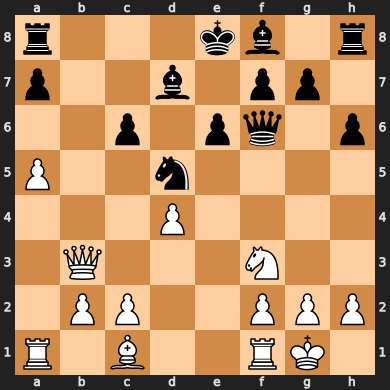

In [19]:
def check_model_prediction(model: torch.nn.Module,
                           random_fen: str,
                           fen_class: int,
                           device=device):
    """Takes the given fen to see the board, predicted score and actual score"""

    numpy_fen = fen_to_tensor(random_fen)
    torch_fen = torch.tensor(numpy_fen, dtype=torch.float32).unsqueeze(0).to(device)
    pred = torch.argmax(model(torch_fen), dim=-1)
    print("Model Prediction: ", pred.item())
    print("Stockfish Evaluation: ", fen_class)

# Remember to update fen_class manually
random_fen = "r3kb1r/p2b1pp1/2p1pq1p/P2n4/3P4/1Q3N2/1PP2PPP/R1B2RK1 b kq - 2 14"
check_model_prediction(model=model,
                       random_fen=random_fen,
                       fen_class=5, # remember to manually set 
                       device=device)

board = chess.Board(random_fen)
board

In [21]:
from sklearn.metrics import classification_report

all_preds = []
all_labels = []

model.eval()
with torch.inference_mode():
    for X, y in val_dataloader:
        X, y = X.to(device), y.to(device)
        preds = model(X).argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())

        # all_labels.extend(y.cpu().numpy())
        true_labels = y.argmax(dim=1) 
        all_labels.extend(true_labels.cpu().numpy())

print(classification_report(all_labels, all_preds))


              precision    recall  f1-score   support

           0       0.84      0.81      0.82     85756
           1       0.65      0.63      0.64     85446
           2       0.63      0.63      0.63     85601
           3       0.62      0.68      0.65     86225
           4       0.65      0.66      0.66     85229
           5       0.65      0.65      0.65     85573
           6       0.84      0.81      0.82     85377

    accuracy                           0.70    599207
   macro avg       0.70      0.70      0.70    599207
weighted avg       0.70      0.70      0.70    599207



In [22]:
import json
import time

LOGS_DIR = f"experiments/logs/{model_save_name}"

def save_config_metadata(experiment_name: str, 
                         model: torch.nn.Module, 
                         hyperparams: dict, 
                         dataset_paths: dict,
                         save_dir: str = LOGS_DIR):
    """
    Saves all 'static' setup details: Model architecture, parameter counts, 
    datasets used, and hyperparameters.
    """
    Path(save_dir).mkdir(parents=True, exist_ok=True)

    # Model Metadata
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    config_data = {
        "experiment_name": experiment_name,
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
        "model_architecture": {
            "class_name": model.__class__.__name__,
            "total_parameters": total_params,
            "trainable_parameters": trainable_params,
            "input_dim": hyperparams.get("input_shape", "unknown"),
            "output_dim": hyperparams.get("output_shape", "unknown"),
            "structure_summary": str(model)
        },
        "datasets": dataset_paths,
        "hyperparameters": hyperparams,
        "device": torch.cuda.get_device_name() if torch.cuda.is_available() else "cpu"
    }

    file_path = f"{save_dir}/{experiment_name}_config.json"
    with open(file_path, "w") as f:
        json.dump(config_data, f, indent=4)
    
    print(f"[Config] Saved metadata to {file_path}")
    
def save_training_logs(experiment_name: str, 
                       results_dict: dict, 
                       save_dir: str = LOGS_DIR):
    """
    Saves the epoch-by-epoch learning curves (Loss/Acc) to CSV.
    Expects results_dict to be the output from your run_experiment function.
    """
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    
    df = pd.DataFrame(results_dict)
    
    if "epoch" not in df.columns:
        df["epoch"] = range(1, len(df) + 1)
        
    file_path = f"{save_dir}/{experiment_name}_learning_curves.csv"
    df.to_csv(file_path, index=False)
    
    print(f"[Logs] Saved training history to {file_path}")

In [25]:
import numpy as np
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from typing import List, Dict, Tuple

RESULTS_DIR = f"experiments/results/{model_save_name}"

def calculate_ordinal_metrics(preds: np.ndarray,
                              labels: np.ndarray) -> Dict[str, float]:
    """
    Calculates metrics specific to ordinal classification (where Class 0 is close to Class 1).
    """
    abs_diffs = np.abs(preds - labels)
    
    metrics = {
        "mae": float(np.mean(abs_diffs)),
        "off_by_one_accuracy": float(np.mean(abs_diffs <= 1)),
        "off_by_two_accuracy": float(np.mean(abs_diffs <= 2))
    }
    return metrics

def categorize_failures(preds: np.ndarray, 
                        labels: np.ndarray) -> Dict[int, List[int]]:
    """
    Categorizes errors by magnitude.
    Returns a dict where keys are the error magnitude (3, 4, 5, 6) and values are lists of dataset indices.
    """
    abs_diffs = np.abs(preds - labels)
    failure_dict = {}
    
    # We care about errors >= 3 (e.g. Predicting 'Equal' when 'Black Winning')
    # Max error is 6 (Predicting 'White Winning' when 'Black Winning')
    for magnitude in range(3, 7):
        indices = np.where(abs_diffs == magnitude)[0].tolist()
        if indices:
            failure_dict[magnitude] = indices
            
    return failure_dict

def run_inference(model: torch.nn.Module, 
                  dataloader: torch.utils.data.DataLoader, 
                  device: str) -> Tuple[np.ndarray, np.ndarray, float]:
    """
    Runs inference and tracks latency. Returns predictions, true labels, and avg latency per sample (ms).
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    start_time = time.time()
    
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            preds = model(X).argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())

            # all_labels.extend(y.cpu().numpy())
            true_labels = y.argmax(dim=1) 
            all_labels.extend(true_labels.cpu().numpy())
            
    total_time = time.time() - start_time
    num_samples = len(all_labels)
    avg_latency_ms = (total_time / num_samples) * 1000
    
    return np.array(all_preds), np.array(all_labels), avg_latency_ms

def save_test_results(experiment_name: str, 
                      model: torch.nn.Module, 
                      test_dataloader: torch.utils.data.DataLoader, 
                      device: str,
                      save_dir: str = RESULTS_DIR):
    """
    Orchestrates the testing process and saves all research-grade metrics.
    """
    Path(save_dir).mkdir(parents=True, exist_ok=True)
        
    preds, labels, latency_ms = run_inference(model, test_dataloader, device)

    acc = accuracy_score(labels, preds)
    class_report = classification_report(labels, preds, output_dict=True)
    conf_matrix = confusion_matrix(labels, preds)
    ordinal_metrics = calculate_ordinal_metrics(preds, labels)
    failure_indices = categorize_failures(preds, labels)
    
    final_metrics = {
        "experiment_name": experiment_name,
        "global_accuracy": acc,
        "inference_latency_ms": latency_ms,
        "ordinal_metrics": ordinal_metrics,
        "catastrophic_failure_counts": {k: len(v) for k, v in failure_indices.items()},
        "classification_report": class_report
    }

    json_path = f"{save_dir}/{experiment_name}_metrics.json"
    with open(json_path, "w") as f:
        json.dump(final_metrics, f, indent=4)
        
    npy_path = f"{save_dir}/{experiment_name}_confusion_matrix.npy"
    np.save(npy_path, conf_matrix)
    
    # Failure Indices JSON (for later visual analysis of specific FENs)
    failures_path = f"{save_dir}/{experiment_name}_failure_indices.json"
    with open(failures_path, "w") as f:
        json.dump(failure_indices, f)
    
    print("-" * 60)
    print(f"[Results] Accuracy:        {acc*100:.2f}%")
    print(f"[Results] Off-by-1 Acc:    {ordinal_metrics['off_by_one_accuracy']*100:.2f}%")
    print(f"[Results] MAE:             {ordinal_metrics['mae']:.4f}")
    print(f"[Results] Latency:         {latency_ms:.4f} ms/sample")
    print("[Results] Catastrophic Failures (Count):")
    for k in sorted(failure_indices.keys()):
        print(f"   - Off by {k}: {len(failure_indices[k])} samples")
    print(f"[Results] Saved all metrics to {save_dir}")
    print("-" * 60)


In [26]:
hyperparams = {
    "epochs": NUM_EPOCHS,
    "batch_size": BATCH_SIZE,
    "learning_rate": 0.001,
    "optimizer": "AdamW",
    "input_shape": 775,
    "output_shape": 7
}

dataset_paths = {
    "train": str(TRAIN_PATH),
    "val":   str(VAL_PATH),
    "test":  str(TEST_PATH)
}

save_config_metadata(experiment_name=RUN_ID,
                     model=model,
                     hyperparams=hyperparams,
                     dataset_paths=dataset_paths)

# Save Training Logs (Using the 'result' variable from run_experiment)
save_training_logs(experiment_name=RUN_ID, 
                   results_dict=result)

save_test_results(experiment_name=RUN_ID,
                  model=model,
                  test_dataloader=test_dataloader,
                  device=device)

[Config] Saved metadata to experiments/logs/probs_seresnet_droppath_c128_bn_v8/run_2026_01_15_probs_seresnet_droppath_c128_bn_v8_config.json
[Logs] Saved training history to experiments/logs/probs_seresnet_droppath_c128_bn_v8/run_2026_01_15_probs_seresnet_droppath_c128_bn_v8_learning_curves.csv
------------------------------------------------------------
[Results] Accuracy:        69.20%
[Results] Off-by-1 Acc:    94.73%
[Results] MAE:             0.3873
[Results] Latency:         0.0773 ms/sample
[Results] Catastrophic Failures (Count):
   - Off by 3: 7977 samples
   - Off by 4: 1744 samples
   - Off by 5: 908 samples
   - Off by 6: 407 samples
[Results] Saved all metrics to experiments/results/probs_seresnet_droppath_c128_bn_v8
------------------------------------------------------------


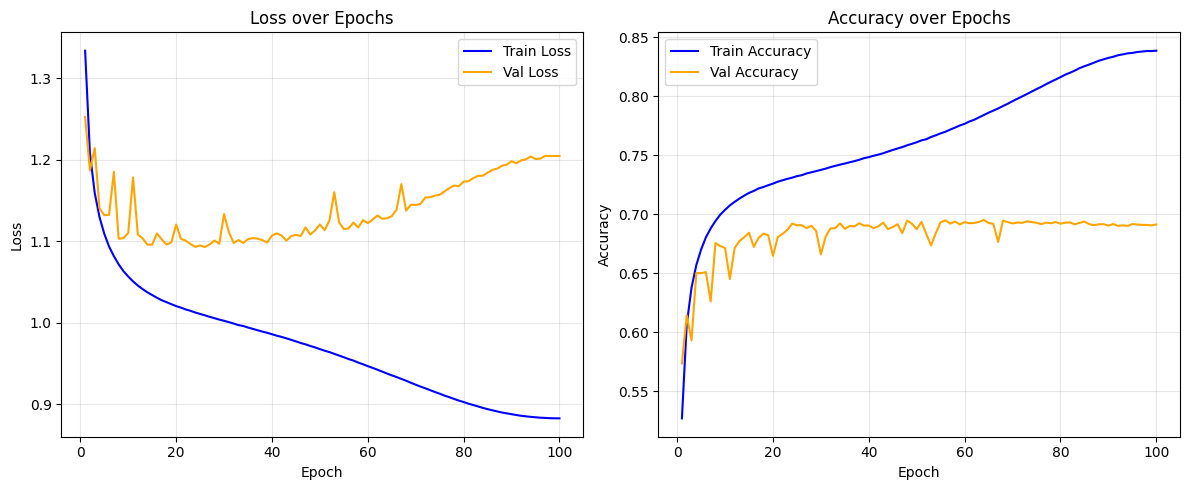

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = Path(f"./experiments/logs/{model_save_name}/{RUN_ID}_learning_curves.csv")
df = pd.read_csv(file_path)

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(df['epoch'], df['train_loss'], label='Train Loss', color='blue')
plt.plot(df['epoch'], df['val_loss'], label='Val Loss', color='orange')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(df['epoch'], df['train_acc'], label='Train Accuracy', color='blue')
plt.plot(df['epoch'], df['val_acc'], label='Val Accuracy', color='orange')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

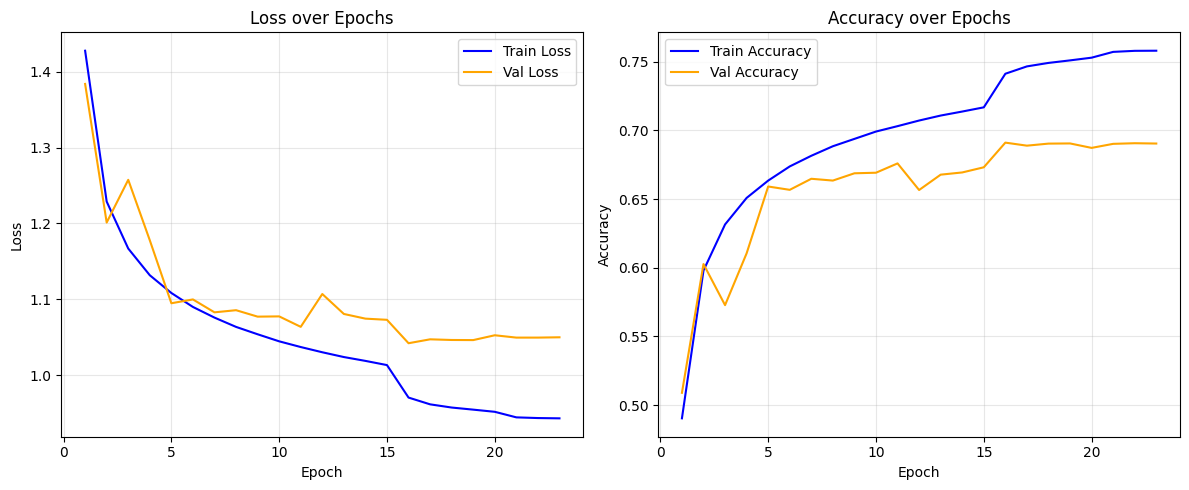

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = Path(f"./experiments/logs/seresnet_ls_droppath_64_v4/run_2026_01_10_seresnet_ls_droppath_reduced_v6_learning_curves.csv")
df = pd.read_csv(file_path)

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(df['epoch'], df['train_loss'], label='Train Loss', color='blue')
plt.plot(df['epoch'], df['val_loss'], label='Val Loss', color='orange')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(df['epoch'], df['train_acc'], label='Train Accuracy', color='blue')
plt.plot(df['epoch'], df['val_acc'], label='Val Accuracy', color='orange')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()